In [1]:
# Cell 1 — Mount Drive & install packages
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install -q rapidfuzz xgboost joblib


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.2 MB/s eta 0:00:00


In [2]:
# Cell 2 — imports & settings
import os, re, unicodedata, math
from pathlib import Path
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, classification_report, confusion_matrix, brier_score_loss
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import joblib
pd.set_option('display.max_colwidth', 200)
RND = 42


In [3]:
# Cell 3 — paths & load CSVs (update base if needed)
base = "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics"
p = Path(base)
assert p.exists(), f"Base path does not exist: {base}"

paths = {
    'main': p / "chemicals-in-cosmetics.csv",
    'prop65': p / "proposition65_clean.csv",
    'iarc': p / "List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv",
    'toxcast': p / "Chemical List toxcast-2025-08-08.csv",
    'cosing': p / "coslng" / "COSING_Ingredients-Fragrance Inventory_v2.csv"
}

for k,fp in paths.items():
    print(k, "->", fp, "exists?", fp.exists())
    if not fp.exists():
        raise FileNotFoundError(f"Missing {k} at {fp}. Upload or correct path before proceeding.")

# Load (use low_memory=False to avoid mixed types)
main_df = pd.read_csv(paths['main'], low_memory=False)
prop65_df = pd.read_csv(paths['prop65'], low_memory=False)
iarc_df = pd.read_csv(paths['iarc'], low_memory=False)
toxcast_df = pd.read_csv(paths['toxcast'], low_memory=False)
cosing_df = pd.read_csv(paths['cosing'], low_memory=False)

print("Shapes:")
print("main", main_df.shape)
print("prop65", prop65_df.shape)
print("iarc", iarc_df.shape)
print("toxcast", toxcast_df.shape)
print("cosing", cosing_df.shape)


main -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/chemicals-in-cosmetics.csv exists? True
prop65 -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/proposition65_clean.csv exists? True
iarc -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv exists? True
toxcast -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/Chemical List toxcast-2025-08-08.csv exists? True
cosing -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Ingredients-Fragrance Inventory_v2.csv exists? True
Shapes:
main (112870, 22)
prop65 (1038, 6)
iarc (1121, 7)
toxcast (4746, 14)
cosing (30080, 10)


In [4]:
# Cell 4 — normalization helpers
cas_re = re.compile(r'(\d{1,7}\-\d{1,2}\-\d{1})')

def normalize_text(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    s = re.sub(r'[^a-z0-9\-\.,\(\)\/\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def extract_cas(s):
    if pd.isna(s): return ""
    s = str(s)
    m = cas_re.search(s)
    if m:
        return m.group(1)
    return ""


In [5]:
# Cell 5 — auto-detect columns in main and normalize
def find_col(df, candidates):
    cols = df.columns.tolist()
    for cand in candidates:
        for col in cols:
            if cand.lower() in col.lower():
                return col
    return None

chem_col = find_col(main_df, ['ChemicalName','Ingredient','Chemical Name','INCI'])
cas_col = find_col(main_df, ['CasNumber','Cas Number','CAS','CASRN'])
prod_col = find_col(main_df, ['ProductName','Product Name','Product'])
brand_col = find_col(main_df, ['BrandName','Brand','CompanyName','Company'])

print("Detected columns:", dict(chemical=chem_col, cas=cas_col, product=prod_col, brand=brand_col))

# Create normalized columns
main_df['_chem_raw'] = main_df[chem_col].astype(str)
main_df['_chem_norm'] = main_df['_chem_raw'].apply(normalize_text)
main_df['_cas_raw'] = main_df[cas_col].astype(str) if cas_col else ""
main_df['_cas'] = main_df['_cas_raw'].apply(extract_cas)
main_df['_product_name'] = main_df[prod_col].astype(str)
main_df['_brand'] = main_df[brand_col].astype(str)
# product id
main_df['_product_id'] = main_df['_brand'].str.strip() + "||" + main_df['_product_name'].str.strip()

print("Sample normalized rows:")
display(main_df[['_product_id','_chem_raw','_chem_norm','_cas']].head(8))


Detected columns: {'chemical': 'ChemicalName', 'cas': 'CasNumber', 'product': 'ProductName', 'brand': 'BrandName'}
Sample normalized rows:


,_product_id,_chem_raw,_chem_norm,_cas
0,AVON||ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,Titanium dioxide,titanium dioxide,13463-67-7
1,Glover's||Glover's Medicated Shampoo,Distillates (coal tar),distillates (coal tar),65996-92-1
2,Glover's||Glover's Medicated Shampoo,Estragole,estragole,140-67-0
3,AVON||PRECISION GLIMMER EYE LINER-ALL SHADES �,Titanium dioxide,titanium dioxide,13463-67-7
4,AVON||AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,Titanium dioxide,titanium dioxide,13463-67-7
5,AVON||JILLIAN DEMPSEY FOR AVON CELESTIAL EYESHADOW-ALL SHADES �,Titanium dioxide,titanium dioxide,13463-67-7
6,OPI||ABSOLUTE Precision Color Powder System - All Shades,Titanium dioxide,titanium dioxide,13463-67-7
7,OPI||ABSOLUTE Precision Color Powder System - All Shades,Titanium dioxide,titanium dioxide,13463-67-7


In [6]:
# Cell 6 — dedupe by product + chem_norm + cas
main_df['_dedupe_key'] = main_df['_product_id'].fillna('') + "||" + main_df['_chem_norm'].fillna('') + "||" + main_df['_cas'].fillna('')
before = len(main_df)
main_dedup = main_df.drop_duplicates(subset=['_dedupe_key']).reset_index(drop=True)
after = len(main_dedup)
print(f"Rows before dedupe: {before:,} -> after: {after:,} (removed {before-after:,})")
# save deduped rows for debugging
processed_dir = Path(base) / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)
main_dedup.to_csv(processed_dir / "main_deduped_rows.csv", index=False)
print("Saved deduped rows ->", processed_dir / "main_deduped_rows.csv")


Rows before dedupe: 112,870 -> after: 39,405 (removed 73,465)
Saved deduped rows -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/main_deduped_rows.csv


In [7]:
# Cell 7 — normalize authoritative lists (get CAS and normalized name)
def auto_find_name_and_cas(df):
    name = find_col(df, ['Name','ChemicalName','INCI','Preferred Name','PREFERRED NAME','SUBSTANCE','Substance'])
    cas = find_col(df, ['CASNumber','CAS Number','CASRN','CAS','CAS No','CAS_No','Registry Number','RN'])
    return name, cas

# Prop65
p65_name_col, p65_cas_col = auto_find_name_and_cas(prop65_df)
print("Prop65 columns:", p65_name_col, p65_cas_col)
prop65_df['_name_norm'] = prop65_df[p65_name_col].astype(str).apply(normalize_text) if p65_name_col else ""
prop65_df['_cas'] = prop65_df[p65_cas_col].astype(str).apply(extract_cas) if p65_cas_col else ""

# IARC
iarc_name_col, iarc_cas_col = auto_find_name_and_cas(iarc_df)
print("IARC columns:", iarc_name_col, iarc_cas_col)
iarc_df['_name_norm'] = iarc_df[iarc_name_col].astype(str).apply(normalize_text) if iarc_name_col else ""
iarc_df['_cas'] = iarc_df[iarc_cas_col].astype(str).apply(extract_cas) if iarc_cas_col else ""

# ToxCast
tox_name_col, tox_cas_col = auto_find_name_and_cas(toxcast_df)
print("ToxCast columns:", tox_name_col, tox_cas_col)
toxcast_df['_name_norm'] = toxcast_df[tox_name_col].astype(str).apply(normalize_text) if tox_name_col else ""
toxcast_df['_cas'] = toxcast_df[tox_cas_col].astype(str).apply(extract_cas) if tox_cas_col else ""

# CosIng
cos_name_col, cos_cas_col = auto_find_name_and_cas(cosing_df)
print("CosIng columns:", cos_name_col, cos_cas_col)
cosing_df['_name_norm'] = cosing_df[cos_name_col].astype(str).apply(normalize_text) if cos_name_col else ""
cosing_df['_cas'] = cosing_df[cos_cas_col].astype(str).apply(extract_cas) if cos_cas_col else ""

# counts
print("Counts: prop65:", prop65_df.shape[0], "iarc:", iarc_df.shape[0], "toxcast:", toxcast_df.shape[0], "cosing:", cosing_df.shape[0])


Prop65 columns: None CAS No.
IARC columns: None CAS No.
ToxCast columns: PREFERRED NAME CASRN
CosIng columns: INCI name CAS No
Counts: prop65: 1038 iarc: 1121 toxcast: 4746 cosing: 30080


In [8]:
# Cell 8 — chemical-level table from deduped main rows
chem_unique = (main_dedup[['_chem_raw','_chem_norm','_cas']]
               .drop_duplicates()
               .rename(columns={'_chem_raw':'chemical_name_raw','_chem_norm':'chemical_name_norm','_cas':'cas'})
               .reset_index(drop=True))
print("Unique chemicals found in data:", len(chem_unique))
display(chem_unique.head(20))
# save
chem_unique.to_csv(processed_dir / "chem_unique_raw.csv", index=False)


Unique chemicals found in data: 157


,chemical_name_raw,chemical_name_norm,cas
0,Titanium dioxide,titanium dioxide,13463-67-7
1,Distillates (coal tar),distillates (coal tar),65996-92-1
2,Estragole,estragole,140-67-0
3,Cocamide diethanolamine,cocamide diethanolamine,68603-42-9
4,Toluene,toluene,108-88-3
5,Cocamide diethanolamine,cocamide diethanolamine,
6,Chromium (hexavalent compounds),chromium (hexavalent compounds),
7,Retinol,retinol,68-26-8
8,"Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.","retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.",79-81-2
9,Vitamin A,vitamin a,11103-57-4


In [9]:
# Cell 9 — exact-match labeling using CAS then name
# sets
prop65_cas = set(prop65_df['_cas'].dropna().astype(str).unique())
iarc_cas = set(iarc_df['_cas'].dropna().astype(str).unique())
tox_cas = set(toxcast_df['_cas'].dropna().astype(str).unique())

prop65_names = set(prop65_df['_name_norm'].dropna().unique())
iarc_names = set(iarc_df['_name_norm'].dropna().unique())
tox_names = set(toxcast_df['_name_norm'].dropna().unique())
cosing_names = set(cosing_df['_name_norm'].dropna().unique())

def label_from_authorities(row):
    cas = str(row['cas']) if row['cas'] and str(row['cas']).strip()!='' else ''
    name = row['chemical_name_norm']
    flags = {
        'prop65_cas': cas in prop65_cas,
        'iarc_cas': cas in iarc_cas,
        'tox_cas': cas in tox_cas,
        'prop65_name': name in prop65_names,
        'iarc_name': name in iarc_names,
        'tox_name': name in tox_names
    }
    flags['any_exact'] = any(flags.values())
    return pd.Series(flags)

chem_flags = chem_unique.apply(label_from_authorities, axis=1)
chem = pd.concat([chem_unique, chem_flags], axis=1)
chem['flag_exact'] = chem['any_exact']
print("Exact matches (cas or name):", chem['flag_exact'].sum(), " / ", len(chem))
chem.head(20)


Exact matches (cas or name): 129  /  157


,chemical_name_raw,chemical_name_norm,cas,prop65_cas,iarc_cas,tox_cas,prop65_name,iarc_name,tox_name,any_exact,flag_exact
0,Titanium dioxide,titanium dioxide,13463-67-7,False,True,False,False,False,False,True,True
1,Distillates (coal tar),distillates (coal tar),65996-92-1,False,False,False,False,False,False,False,False
2,Estragole,estragole,140-67-0,True,False,True,False,False,True,True,True
3,Cocamide diethanolamine,cocamide diethanolamine,68603-42-9,False,True,False,False,False,False,True,True
4,Toluene,toluene,108-88-3,True,True,False,False,False,False,True,True
5,Cocamide diethanolamine,cocamide diethanolamine,,True,True,True,False,False,False,True,True
6,Chromium (hexavalent compounds),chromium (hexavalent compounds),,True,True,True,False,False,False,True,True
7,Retinol,retinol,68-26-8,False,False,True,False,False,True,True,True
8,"Retinol/retinyl esters, when in daily dosages in excess of 10,000 IU, or 3,000 retinol equivalents.","retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.",79-81-2,False,False,True,False,False,False,True,True
9,Vitamin A,vitamin a,11103-57-4,False,False,False,False,False,False,False,False


In [10]:
# Cell 10 — fuzzy-match remaining names (fallback)
auth_names = list(prop65_names | iarc_names | tox_names | cosing_names)
print("Auth name pool size:", len(auth_names))

def fuzzy_map(name, choices, score_cutoff=90):
    if not name or name.strip()=='':
        return None, 0
    match = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= score_cutoff:
        return match[0], match[1]
    return None, 0

# apply to rows not exact-matched
chem['fuzzy_match_name'] = None
chem['fuzzy_score'] = np.nan
to_fuzzy_idx = chem[~chem['flag_exact']].index.tolist()
print("To fuzzy-match:", len(to_fuzzy_idx))
for idx in tqdm(to_fuzzy_idx):
    name = chem.at[idx, 'chemical_name_norm']
    best_name, score = fuzzy_map(name, auth_names, score_cutoff=88)  # 88 conservative
    chem.at[idx, 'fuzzy_match_name'] = best_name
    chem.at[idx, 'fuzzy_score'] = score
chem['flag_fuzzy'] = chem['fuzzy_match_name'].notna()
chem['flag_any'] = chem['flag_exact'] | chem['flag_fuzzy']
print("After fuzzy matching, flagged chemicals:", chem['flag_any'].sum())
# Save chemical label file
chem.to_csv(processed_dir / "chemical_labels_from_main.csv", index=False)
print("Saved chemical_labels_from_main.csv")


Auth name pool size: 34331
To fuzzy-match: 28


  0%|          | 0/28 [00:00<?, ?it/s]

After fuzzy matching, flagged chemicals: 143
Saved chemical_labels_from_main.csv


In [11]:
# Cell 11 — save fuzzy matches sample for manual inspection
fuzzy_sample = chem[chem['flag_fuzzy']].copy().sort_values('fuzzy_score', ascending=False)
fuzzy_sample.head(200).to_csv(processed_dir / "fuzzy_matched_sample.csv", index=False)
print("Saved fuzzy sample for manual review:", processed_dir / "fuzzy_matched_sample.csv")
display(fuzzy_sample.head(20))


Saved fuzzy sample for manual review: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/fuzzy_matched_sample.csv


,chemical_name_raw,chemical_name_norm,cas,prop65_cas,iarc_cas,tox_cas,prop65_name,iarc_name,tox_name,any_exact,flag_exact,fuzzy_match_name,fuzzy_score,flag_fuzzy,flag_any
30,Titanium dioxide,titanium dioxide,1317-70-0,False,False,False,False,False,False,False,False,titanium dioxide,100.000000,True,True
31,Mica,mica,12001-26-2,False,False,False,False,False,False,False,False,mica,100.000000,True,True
73,Titanium dioxide,titanium dioxide,98084-96-9,False,False,False,False,False,False,False,False,titanium dioxide,100.000000,True,True
71,Methylene glycol,methylene glycol,463-57-0,False,False,False,False,False,False,False,False,methylene glycol,100.000000,True,True
75,Lauramide DEA,lauramide dea,120-40-1,False,False,False,False,False,False,False,False,lauramide dea,100.000000,True,True
81,Coal Tar,coal tar,8002-45-2,False,False,False,False,False,False,False,False,coal tar,100.000000,True,True
107,Selenium sulfide,selenium sulfide,7488-56-4,False,False,False,False,False,False,False,False,selenium sulfide,100.000000,True,True
88,Sodium Bromate,sodium bromate,7789-38-0,False,False,False,False,False,False,False,False,sodium bromate,100.000000,True,True
102,Titanium dioxide,titanium dioxide,1317-80-2,False,False,False,False,False,False,False,False,titanium dioxide,100.000000,True,True
103,Retinyl palmitate,retinyl palmitate,79-82-1,False,False,False,False,False,False,False,False,retinyl palmitate,100.000000,True,True


In [12]:
# Cell 12 — create per-product unique ingredient lists and honest labels
# create a lookup for chemical flag (use cas if present else normalized name or fuzzy)
flagged_cas_set = set(chem.loc[chem['flag_any']==True, 'cas'].dropna().astype(str).unique())
flagged_name_set = set(chem.loc[chem['flag_any']==True, 'chemical_name_norm'].dropna().unique())

def is_chem_flagged(chem_norm, cas):
    if cas and str(cas).strip()!='' and str(cas) in flagged_cas_set:
        return True
    if chem_norm and chem_norm in flagged_name_set:
        return True
    return False

# build per-product aggregation using main_dedup
prod_records = []
for pid, g in tqdm(main_dedup.groupby('_product_id'), desc="Aggregating products"):
    unique_pairs = g.drop_duplicates(subset=['_chem_norm','_cas'])
    unique_ing_names = list(unique_pairs['_chem_norm'].unique())
    unique_cas = [c for c in unique_pairs['_cas'].unique() if c and str(c).strip()!='']
    # flagged unique ingredients count
    flagged_mask = unique_pairs.apply(lambda r: is_chem_flagged(r['_chem_norm'], r['_cas']), axis=1)
    flagged_unique_count = int(flagged_mask.sum())
    total_unique = int(unique_pairs['_chem_norm'].nunique())
    prod_records.append({
        '_product_id': pid,
        'product_name': g['_product_name'].iloc[0],
        'brand': g['_brand'].iloc[0],
        'unique_ingredients': unique_ing_names,
        'unique_cas_list': unique_cas,
        'unique_num_ingredients': total_unique,
        'unique_flagged_count': flagged_unique_count,
        'unique_flagged_fraction': (flagged_unique_count / total_unique) if total_unique>0 else 0.0
    })

prod_agg_fixed = pd.DataFrame(prod_records)
prod_agg_fixed['product_label'] = (prod_agg_fixed['unique_flagged_count'] > 0).astype(int)
print("Products aggregated (fixed):", prod_agg_fixed.shape[0])
prod_agg_fixed.head(6)
# save
prod_agg_fixed.to_csv(processed_dir / "product_level_flags_fixed.csv", index=False)
print("Saved product_level_flags_fixed.csv")


Aggregating products:   0%|          | 0/34751 [00:00<?, ?it/s]

Products aggregated (fixed): 34751
Saved product_level_flags_fixed.csv


In [13]:
# Cell 13 — sanity checks
pf = prod_agg_fixed.copy()
print("Total products:", len(pf))
print("Positive products (product_label==1):", pf['product_label'].sum(), f"({pf['product_label'].mean()*100:.2f}%)")
print("\nunique_num_ingredients stats:")
print(pf['unique_num_ingredients'].describe())
print("\nunique_flagged_fraction stats:")
print(pf['unique_flagged_fraction'].describe())

# show sample positives and negatives
print("\nSample positives (product_label==1):")
display(pf[pf['product_label']==1].sample(min(8, pf['product_label'].sum())))
print("\nSample negatives (product_label==0):")
display(pf[pf['product_label']==0].sample(8))


Total products: 34751
Positive products (product_label==1): 34729 (99.94%)

unique_num_ingredients stats:
count    34751.000000
mean         1.133262
std          0.407408
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: unique_num_ingredients, dtype: float64

unique_flagged_fraction stats:
count    34751.000000
mean         0.999683
std          0.034896
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: unique_flagged_fraction, dtype: float64

Sample positives (product_label==1):


,_product_id,product_name,brand,unique_ingredients,unique_cas_list,unique_num_ingredients,unique_flagged_count,unique_flagged_fraction,product_label
9066,DECLEOR||VITAROMA - Soin contour yeux dynamisant / ENERGISING EYE CREAM,VITAROMA - Soin contour yeux dynamisant / ENERGISING EYE CREAM,DECLEOR,[vitamin a palmitate],[79-81-2],1,1,1.0,1
455,AVOJUICE SKIN QUENCHERS||Candy Cane Juicie,Candy Cane Juicie,AVOJUICE SKIN QUENCHERS,[titanium dioxide],[13463-67-7],1,1,1.0,1
521,AVON||AVON ELEMENTS YOUTH RESTORING ANTI-WRINKLE NIGHT CREAM,AVON ELEMENTS YOUTH RESTORING ANTI-WRINKLE NIGHT CREAM,AVON,[titanium dioxide],[13463-67-7],1,1,1.0,1
9792,Dr. Lewinn by Kinerase||Instant Dermal Wrinkle Filler,Instant Dermal Wrinkle Filler,Dr. Lewinn by Kinerase,[oil orange ss],[2646-17-5],1,1,1.0,1
26750,SENSAI CELLULAR PERFORMANCE||CREAM FOUNDATION CF12 SUMMER BREEZE,CREAM FOUNDATION CF12 SUMMER BREEZE,SENSAI CELLULAR PERFORMANCE,[titanium dioxide],[13463-67-7],1,1,1.0,1
20805,Mirabella||Lip Definer Bratty,Lip Definer Bratty,Mirabella,[titanium dioxide],[13463-67-7],1,1,1.0,1
19725,MAMONDE||VIVIDE TOUCH MOISTURE LIPSTICK #12,VIVIDE TOUCH MOISTURE LIPSTICK #12,MAMONDE,[titanium dioxide],[13463-67-7],1,1,1.0,1
32059,Victoria's Secret Beauty||Heidi Klum for VS Make Up- Eye Shadow Mosaic,Heidi Klum for VS Make Up- Eye Shadow Mosaic,Victoria's Secret Beauty,[titanium dioxide],[13463-67-7],1,1,1.0,1



Sample negatives (product_label==0):


,_product_id,product_name,brand,unique_ingredients,unique_cas_list,unique_num_ingredients,unique_flagged_count,unique_flagged_fraction,product_label
34127,glominerals||Smoothing Salt Scrub,Smoothing Salt Scrub,glominerals,[vitamin a],[11103-57-4],1,0,0.0,0
24053,Paula's Choice||Skin Recovery Super Antioxidant Concentrate Serum,Skin Recovery Super Antioxidant Concentrate Serum,Paula's Choice,[vitamin a],[11103-57-4],1,0,0.0,0
34184,glotherapeutics||Renew Serum,Renew Serum,glotherapeutics,[vitamin a],[11103-57-4],1,0,0.0,0
17789,LBEL||ESSENTIAL deep moisturizing and oxygenating cream SPF 20 normal to dry skin,ESSENTIAL deep moisturizing and oxygenating cream SPF 20 normal to dry skin,LBEL,[avobenzone],[70356-09-1],1,0,0.0,0
23503,PRIORI Advanced AHA||SKIN RENEWAL CREAM,SKIN RENEWAL CREAM,PRIORI Advanced AHA,[vitamin a],[11103-57-4],1,0,0.0,0
23501,PRIORI Advanced AHA||Professional Skin Renewal System,Professional Skin Renewal System,PRIORI Advanced AHA,[vitamin a],[11103-57-4],1,0,0.0,0
24037,Paula's Choice||Resist Barrier Repair Targeted Moisturizer,Resist Barrier Repair Targeted Moisturizer,Paula's Choice,[vitamin a],[11103-57-4],1,0,0.0,0
25473,Revision Skincare||Retinol Eye Repair,Retinol Eye Repair,Revision Skincare,[vitamin a],[11103-57-4],1,0,0.0,0


In [14]:
# Cell 14 — prepare text-only features (TF-IDF on product_name + brand)
pf = prod_agg_fixed.copy()
pf['product_text'] = (pf['product_name'].fillna('') + " " + pf['brand'].fillna('')).str.strip()
y = pf['product_label'].values

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=2)
X_text = tfidf.fit_transform(pf['product_text'].values)
print("TF-IDF shape:", X_text.shape)

# split (stratified)
X_tr, X_te, y_tr, y_te, idx_tr, idx_te = train_test_split(X_text, y, pf.index.values, test_size=0.20, random_state=RND, stratify=y)
print("Train positives:", y_tr.sum(), "Test positives:", y_te.sum())


TF-IDF shape: (34751, 2000)
Train positives: 27782 Test positives: 6947


In [15]:
# Cell 15 — train text-only logistic regression & XGBoost, evaluate
clf_lr_text = LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', random_state=RND)
clf_lr_text.fit(X_tr, y_tr)
probs_lr_text = clf_lr_text.predict_proba(X_te)[:,1]

clf_xgb_text = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RND, verbosity=0)
clf_xgb_text.fit(X_tr, y_tr)
probs_xgb_text = clf_xgb_text.predict_proba(X_te)[:,1]

def eval_preds(y_true, scores, name, thresh=0.5):
    print(f"=== {name} ===")
    print("AUROC:", roc_auc_score(y_true, scores) if len(np.unique(y_true))>1 else 'n/a')
    print("AUPRC:", average_precision_score(y_true, scores) if len(np.unique(y_true))>1 else 'n/a')
    print("Brier:", brier_score_loss(y_true, scores))
    pred = (scores >= thresh).astype(int)
    print("Confusion:\n", confusion_matrix(y_true, pred))
    print(classification_report(y_true, pred, zero_division=0))
    # precision@k
    idx_sorted = np.argsort(-scores)
    for k in (10,50,100):
        k = min(k, len(scores))
        p_at_k = y_true[idx_sorted[:k]].sum() / k
        print(f"Precision@{k}: {p_at_k:.4f}")
    print()

eval_preds(y_te, probs_lr_text, "Logistic (text-only)")
eval_preds(y_te, probs_xgb_text, "XGBoost (text-only)")

# Save text-only models & vectorizer
model_dir = Path(base) / "trained_models"
model_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(tfidf, model_dir / "tfidf_textonly.joblib")
joblib.dump(clf_lr_text, model_dir / "clf_lr_textonly.joblib")
joblib.dump(clf_xgb_text, model_dir / "clf_xgb_textonly.joblib")
print("Saved text-only models")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Logistic (text-only) ===
AUROC: 0.9366633079026918
AUPRC: 0.9999599743819888
Brier: 0.11603197962805724
Confusion:
 [[   3    1]
 [ 880 6067]]
              precision    recall  f1-score   support

           0       0.00      0.75      0.01         4
           1       1.00      0.87      0.93      6947

    accuracy                           0.87      6951
   macro avg       0.50      0.81      0.47      6951
weighted avg       1.00      0.87      0.93      6951

Precision@10: 1.0000
Precision@50: 1.0000
Precision@100: 1.0000

=== XGBoost (text-only) ===
AUROC: 0.8034763207139772
AUPRC: 0.9997856500195478
Brier: 0.000574827622087143
Confusion:
 [[   0    4]
 [   0 6947]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00      6947

    accuracy                           1.00      6951
   macro avg       0.50      0.50      0.50      6951
weighted avg       1.00      1.00      1.0

In [16]:
# Cell 16 — 5-fold stratified CV for text-only XGB (stability)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
aucs = []; auprcs = []
X_all = tfidf.transform(pf['product_text'].values)
y_all = pf['product_label'].values
for train_idx, test_idx in skf.split(X_all, y_all):
    clf = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RND, verbosity=0)
    clf.fit(X_all[train_idx], y_all[train_idx])
    p = clf.predict_proba(X_all[test_idx])[:,1]
    aucs.append(roc_auc_score(y_all[test_idx], p) if len(np.unique(y_all[test_idx]))>1 else np.nan)
    auprcs.append(average_precision_score(y_all[test_idx], p) if len(np.unique(y_all[test_idx]))>1 else np.nan)
print("CV AUROC mean±std:", np.nanmean(aucs), np.nanstd(aucs))
print("CV AUPRC mean±std:", np.nanmean(auprcs), np.nanstd(auprcs))


CV AUROC mean±std: 0.6179089033430162 0.111148579793243
CV AUPRC mean±std: 0.9995544357697582 0.00012644958357924455


In [17]:
# Cell 17 — rule baseline: product is positive if any unique ingredient matches authoritative list
rule_preds = (pf['unique_flagged_count'] > 0).astype(int)
# evaluate rule against pf labels (this is identity — rule is how we labeled products)
print("Rule baseline (this is same as label generation):")
print("Rule positives:", int(rule_preds.sum()), "Overall positives:", int(pf['product_label'].sum()))
# If you want to evaluate consistency:
print("Rule vs label agreement:", (rule_preds == pf['product_label']).mean())


Rule baseline (this is same as label generation):
Rule positives: 34729 Overall positives: 34729
Rule vs label agreement: 1.0


In [18]:
# Cell 18 — ingredient-presence model (useful to show how much information ingredient lists carry)
# Build MultiLabelBinarizer on top frequent ingredient names to keep model small
all_ings = pf['unique_ingredients'].explode().value_counts()
TOP_K_ING = min(500, len(all_ings))
top_ings = all_ings.index[:TOP_K_ING].tolist()
print("Top ingredients considered:", len(top_ings))

def ing_vectorize(ing_list, top_set):
    return [ing for ing in ing_list if ing in top_set]

mlb = MultiLabelBinarizer(classes=top_ings)
ing_lists_trimmed = pf['unique_ingredients'].apply(lambda L: ing_vectorize(L, set(top_ings)))
X_ing = mlb.fit_transform(ing_lists_trimmed)

print("Ingredient feature shape:", X_ing.shape)
# split (stratify)
Xtr_i, Xte_i, ytr_i, yte_i, idx_tr_i, idx_te_i = train_test_split(X_ing, y, pf.index.values, test_size=0.2, random_state=RND, stratify=y)

# train XGBoost on ingredient presence
clf_xgb_ing = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RND, verbosity=0)
clf_xgb_ing.fit(Xtr_i, ytr_i)
probs_xgb_ing = clf_xgb_ing.predict_proba(Xte_i)[:,1]

eval_preds(yte_i, probs_xgb_ing, "XGB (ingredient-presence)")
# Save mlb and ingredient model
joblib.dump(mlb, model_dir / "mlb_ingredients.joblib")
joblib.dump(clf_xgb_ing, model_dir / "clf_xgb_ing.joblib")
print("Saved ingredient model and mlb")


Top ingredients considered: 123
Ingredient feature shape: (34751, 123)
=== XGB (ingredient-presence) ===
AUROC: 0.9781200518209299
AUPRC: 0.9999748180714383
Brier: 0.0005707015922813567
Confusion:
 [[   0    4]
 [   0 6947]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00      6947

    accuracy                           1.00      6951
   macro avg       0.50      0.50      0.50      6951
weighted avg       1.00      1.00      1.00      6951

Precision@10: 1.0000
Precision@50: 1.0000
Precision@100: 1.0000

Saved ingredient model and mlb


In [19]:
# Cell 19 — Leave-one-ingredient-out for ingredient model (works because ingredient model uses presence features)
# We'll compute per-product deltas by toggling presence of each ingredient in the product's vector
import numpy as np

# helper to compute product probability given binary vector
def prob_from_binary_vector(bin_vec, model):
    # xgboost accept dense array row
    return model.predict_proba(bin_vec.reshape(1, -1))[:,1][0]

# compute LIO for a small set: top K test products by predicted prob
K = 200
probs_all_ing = clf_xgb_ing.predict_proba(X_ing)[:,1]
order = np.argsort(-probs_all_ing)
top_idx_global = order[:K]

lio_records = []
for gi in tqdm(top_idx_global, desc="LIO global"):
    pid = pf.index[gi]
    original_vec = X_ing[gi].copy()
    orig_prob = prob_from_binary_vector(original_vec, clf_xgb_ing)
    # compute deltas for each ingredient present in top_ings
    present_idx = np.where(original_vec==1)[0]
    for j in present_idx:
        vec_wo = original_vec.copy()
        vec_wo[j] = 0
        prob_wo = prob_from_binary_vector(vec_wo, clf_xgb_ing)
        delta = orig_prob - prob_wo
        lio_records.append({
            'product_index': int(gi),
            'product_id': pf.iloc[gi]['_product_id'],
            'ingredient': top_ings[j],
            'delta': float(delta),
            'orig_prob': float(orig_prob)
        })

lio_df_all = pd.DataFrame(lio_records)
# aggregate global importance
global_imp = (lio_df_all.groupby('ingredient')
             .agg(total_delta=('delta','sum'), mean_delta=('delta','mean'), count=('delta','count'))
             .reset_index().sort_values('total_delta', ascending=False))

# save
lio_out = Path(base) / "lio_results"
lio_out.mkdir(parents=True, exist_ok=True)
global_imp.to_csv(lio_out / "global_ingredient_importance_from_ingmodel.csv", index=False)
lio_df_all.to_csv(lio_out / "lio_all_records_ingmodel.csv", index=False)
print("Saved LIO outputs to:", lio_out)
display(global_imp.head(30))


LIO global:   0%|          | 0/200 [00:00<?, ?it/s]

Saved LIO outputs to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results


,ingredient,total_delta,mean_delta,count
3,titanium dioxide,1.369983,0.00685,200
0,ginkgo biloba extract,0.000000,0.00000,1
1,"retinol/retinyl esters, when in daily dosages in excess of 10,000 iu, or 3,000 retinol equivalents.",0.000000,0.00000,10
2,retinyl palmitate,0.000000,0.00000,11


Saved plot to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results/top_20_ingredients_total_delta.png


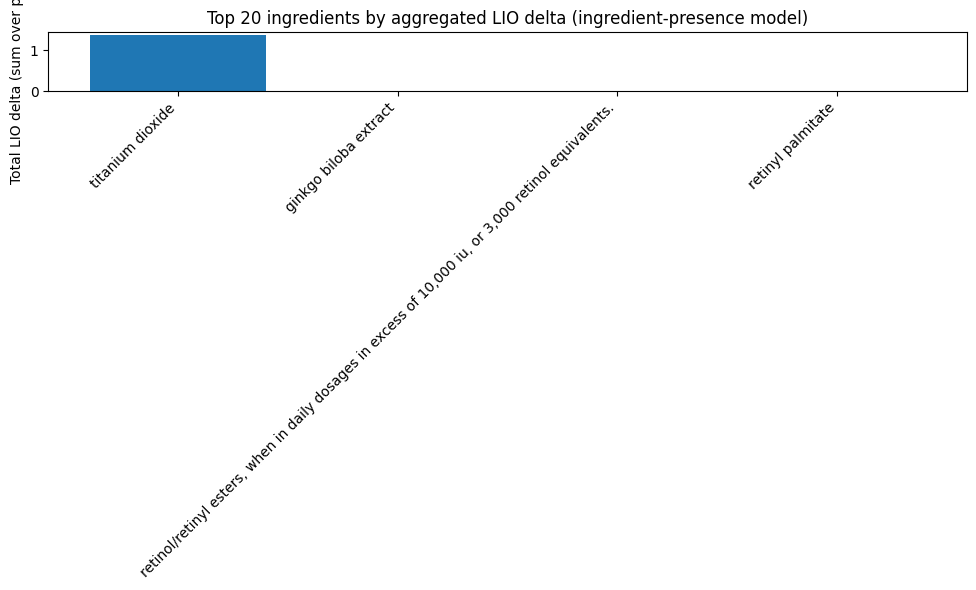

In [20]:
# Cell 20 — plot top-N ingredients by total_delta
TOP_N = 20
g = global_imp.head(TOP_N)
plt.figure(figsize=(10,6))
x = np.arange(len(g))
plt.bar(x, g['total_delta'].values)
plt.xticks(x, g['ingredient'].tolist(), rotation=45, ha='right')
plt.ylabel('Total LIO delta (sum over products)')
plt.title(f'Top {TOP_N} ingredients by aggregated LIO delta (ingredient-presence model)')
plt.tight_layout()
figp = lio_out / f"top_{TOP_N}_ingredients_total_delta.png"
plt.savefig(figp, dpi=200, bbox_inches='tight')
print("Saved plot to:", figp)
plt.show()


In [21]:
# Cell 21 — save artifacts & short README manifest
joblib.dump(clf_xgb_ing, model_dir / "clf_xgb_ing_final.joblib")
joblib.dump(clf_xgb_text, model_dir / "clf_xgb_text_final.joblib")
joblib.dump(clf_lr_text, model_dir / "clf_lr_text_final.joblib")
joblib.dump(tfidf, model_dir / "tfidf_final.joblib")
joblib.dump(mlb, model_dir / "mlb_final.joblib")

# Save cleaned datasets
chem.to_csv(processed_dir / "chemical_labels_final.csv", index=False)
prod_agg_fixed.to_csv(processed_dir / "product_level_flags_final.csv", index=False)

readme = f"""
Pipeline manifest (auto-generated)
Base path: {base}

Saved files:
- processed/main_deduped_rows.csv
- processed/chem_unique_raw.csv
- processed/chemical_labels_from_main.csv
- processed/fuzzy_matched_sample.csv
- processed/product_level_flags_fixed.csv
- processed/product_level_flags_final.csv

Models:
- trained_models/tfidf_final.joblib
- trained_models/clf_lr_text_final.joblib
- trained_models/clf_xgb_text_final.joblib
- trained_models/mlb_final.joblib
- trained_models/clf_xgb_ing_final.joblib

LIO outputs:
- lio_results/global_ingredient_importance_from_ingmodel.csv
- lio_results/lio_all_records_ingmodel.csv
- lio_results/top_{TOP_N}_ingredients_total_delta.png

Notes:
- product_label was generated by conservative matching (CAS-first; then exact/fuzzy name).
- Text-only models (no ingredient-derived features) are the honest ML experiments for ICCIT.
- Ingredient-presence model and LIO demonstrate how ingredient lists can be used for triage; treat with care since labels derive from those same authoritative lists.
"""
(Path(base) / "pipeline_manifest.txt").write_text(readme)
print("Saved manifest and artifacts. Pipeline complete.")


Saved manifest and artifacts. Pipeline complete.
